Neural ODE のデモンストレーション (レーザービーム)

In [111]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from scipy.integrate import solve_ivp

def f(t,z):
    """
     definition of rhs of ode using tensorflow
      args z: 4 dim tensor
    returns: 4dim tensor
    """
    g = 9.8
    return (tf.concat( [z[2:4],[0,-g]],axis=0))



def jacobian(t, f, x):
    """ return jacobian matrix of f at x"""
    n = x.shape[-1].value
    fx = f(t, x)
    if x.shape[-1].value != fx.shape[-1].value:
        print('For calculating Jacobian matrix',
              'dimensions of f(x) and x must be the same')
        return

    return tf.concat([tf.gradients(fx[i], x) for i in range(0, n)], 0)

def Df(t,f,z):
    return jacobian(t,f,z)

class F_np:
    ''' calc rhs of ode (numpy)'''
    def __init__(self,sess,f,z_ph):
        self.f_tf=f(0,z_ph)
        self.sess=sess
        self.z_ph=z_ph
        
    def __call__(self,t,z):
        return( self.sess.run(self.f_tf,
                              feed_dict={self.z_ph:z}) )


class F_with_adjoint_np:
    '''calc ode and adjoint ode (numpy function)'''
    def __init__(self,sess,f,z_ph, a_ph):
        """
         args:
          sess : session
          f: main function of ode
          z_ph: placeholder of main variable z
          a_ph placeholdero f ajoint variable a
        """
        self.dim = 4
        self.fz=f(0,z_ph)
        self.Df=Df(0,f,z_ph)
        self.sess=sess
        self.z_ph=z_ph
        self.a_ph=a_ph
        self.Df_a=-tf.linalg.matvec(self.Df, self.a_ph, transpose_a=True)
        
    def __call__(self,t,za):
        fzv,dav = self.sess.run([self.fz, self.Df_a], 
                       feed_dict={self.z_ph:za[0:4], self.a_ph:za[4:8]})
        return np.concatenate([fzv,dav])

In [112]:
xy_target = (100,0) # target
t_end = 3 # duration of integration
ts=np.arange(0,t_end+0.1,0.1)
dim=4 # dimension of ode


In [113]:
tf.reset_default_graph()

# forward calculation

c = tf.Variable([35,np.pi/4], dtype=tf.float64,
                    name='c') # set initial speed and angle here (unit  km/h to m/s)
z_0 = tf.concat([tf.Variable([0,0,],dtype=tf.float64), [c[0]*tf.cos(c[1])], [c[0]*tf.sin(c[1])]], axis=0)
  
z_T= tf.placeholder(shape=[dim],dtype=tf.float64)
L = tf.reduce_sum(tf.square(z_T[0:2]-xy_target) )

# backward calculation

dLdz_T = tf.gradients(L, z_T)[0]
dLdz_0 = tf.placeholder(shape=[dim],dtype=tf.float64)
#Ldummy
Ldummy0 = tf.reduce_sum(dLdz_0* z_0)

# optimizer and training operator
opt = tf.train.GradientDescentOptimizer(1e-5)
train_op = opt.minimize(Ldummy0, var_list=[c])


In [114]:

## tensors etc used in ODE solvers
z_ph = tf.placeholder(shape=[dim],dtype=tf.float64)
a_ph = tf.placeholder(shape=[dim],dtype=tf.float64)

sess = tf.Session()

f_np = F_np(sess,f,z_ph)
f_with_adj = F_with_adjoint_np(sess,f,z_ph,a_ph)

# variables of numpy arrays end with _val
za_val =np.zeros(shape=[dim*2],dtype=np.float64)

sess.run(tf.initializers.global_variables())

# df= Df(0,f,z_ph)
# a_ph=a_ph
# Df_a=-tf.linalg.matvec(df,a_ph, transpose_a=True)

# check
# print(sess.run(df, feed_dict={z_ph:[0,0,0,0]}))
# print(sess.run(Df_a, feed_dict={z_ph:[0,0,0,0],a_ph:[1,1,1,1]}))

# 前向きと後ろ向き計算の定義

In [115]:
def forward(ts=None):
    z0_val, c_val = sess.run([z_0,c])
    sol = solve_ivp(fun=f_np,
                    t_span=[0, t_end], y0=z0_val, t_eval=ts) #, 
    zt_val = sol['y']
    z_T_val = sol['y'][:,-1]
    L_val = sess.run(L,feed_dict = {z_T:z_T_val})
    return L_val, z_T_val, zt_val,

def backward(z_T_val):
    [dLdz_T_val] = sess.run([dLdz_T],feed_dict={z_T:z_T_val})
    za_val[0:dim] = z_T_val[0:dim]
    za_val[dim:2*dim] = dLdz_T_val[:]
    # backward integration
    sol_back = solve_ivp(fun=f_with_adj,
                    t_span=[t_end, 0], y0=za_val, t_eval=ts[::-1]) #, 

    za_0_val = sol_back['y'][:,-1]
    dLdz_0_val = za_0_val[dim:2*dim]
    #update c
    _,c_val = sess.run([train_op,c], feed_dict={dLdz_0:dLdz_0_val})
    return c_val, dLdz_T_val, dLdz_0_val, za_0_val

# 前向き計算の確認

In [116]:


#forward calculation
L_val, z_T_val, zt_val = forward(ts=ts)

# z_0 and c value
z0_val, c_val = sess.run([z_0,c])
# change to degree
print('(v_0, phi(deg)) = ({:.4}, {:.4}'.format(c_val[0], 360*c_val[1]/(2*np.pi)))
np.set_printoptions(3)
print('z(0)={}'.format(z0_val))

# z(T)
print('z(T)={}'.format(z_T_val))

print('L= {}'.format(L_val))



#sess.close()

(v_0, phi(deg)) = (35.0, 45.0
z(0)=[ 0.     0.    24.749 24.749]
z(T)=[74.246 30.146 24.749 -4.651]
L= 1572.0516945138854


## 軌道の図示

Text(0, 0.5, 'y')

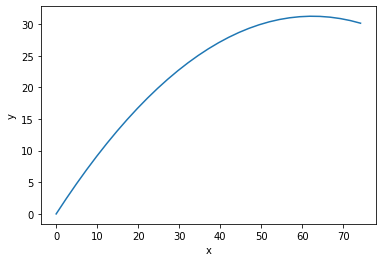

In [117]:
plt.plot(zt_val[0,:],zt_val[1,:])
plt.xlabel('x')
plt.ylabel('y')

# 後ろ向き計算の確認

In [91]:
#backward calculation
c_val, dLdz_T_val, dLdz_0_val, za_0_val = backward(z_T_val)
#    [dLdz_T_val] = sess.run([dLdz_T],feed_dict={z_T:z_T_val})

print('dL/dz(T) = {}'.format(dLdz_T_val))
print('dL/dz(0) = {}'.format(dLdz_0_val))

print('(v_0, phi(deg)) = ({:.3}, {:.3})'.format(c_val[0], 360*c_val[1]/(2*np.pi)))



dL/dz(T) = [-51.508  60.292   0.      0.   ]
dL/dz(0) = [ -51.508   60.292 -154.523  180.877]
(v_0, phi(deg)) = (35.0, 40.2)


# メインの学習ループ

最初の10回は1回ごとに軌道の保存(図を書くため)

In [118]:
orbits = []
n_itr = []

for i in range(11):
    L_val,z_T_val, zt_val = forward()
    c_val, *other = backward(z_T_val)
    
    L_val,z_T_val, zt_val = forward(ts=ts)
    print('iteration:{}'.format(i))
    print('(v_0[m/s], phi[deg]) = ({:.10}, {:.10})'.format(c_val[0], 360*c_val[1]/(2*np.pi)))
    print('L= {:.4}'.format(L_val))
    print('z(T)={}'.format(z_T_val))
        
    orbits.append(zt_val)
    n_itr.append(i)



iteration:0
(v_0[m/s], phi[deg]) = (34.99981365, 40.24403416)
L= 957.5
z(T)=[80.146 23.734 26.715 -6.789]
iteration:1
(v_0[m/s], phi[deg]) = (34.99980291, 36.52096533)
L= 582.0
z(T)=[84.382 18.387 28.127 -8.571]
iteration:2
(v_0[m/s], phi[deg]) = (34.99989946, 33.62470728)
L= 355.2
z(T)=[ 87.431  14.044  29.144 -10.019]
iteration:3
(v_0[m/s], phi[deg]) = (35.0000608, 31.38027123)
L= 219.1
z(T)=[ 89.642  10.575  29.881 -11.175]
iteration:4
(v_0[m/s], phi[deg]) = (35.00026098, 29.64498839)
L= 137.8
z(T)=[ 91.257   7.836  30.419 -12.088]
iteration:5
(v_0[m/s], phi[deg]) = (35.00048435, 28.30522267)
L= 89.41
z(T)=[ 92.447   5.688  30.816 -12.804]
iteration:6
(v_0[m/s], phi[deg]) = (35.00072152, 27.27168578)
L= 60.59
z(T)=[ 93.331   4.013  31.11  -13.362]
iteration:7
(v_0[m/s], phi[deg]) = (35.00096688, 26.47477937)
L= 43.45
z(T)=[ 93.991   2.711  31.33  -13.796]
iteration:8
(v_0[m/s], phi[deg]) = (35.00121708, 25.86050853)
L= 33.27
z(T)=[ 94.488   1.701  31.496 -14.133]
iteration:9
(v_0[m/

軌道が改良されていくことの確認

Text(0, 0.5, 'y')

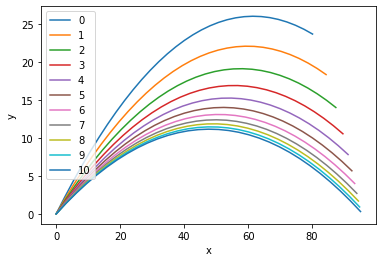

In [119]:
orbits[0].shape
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
for ( i,orb) in zip(n_itr,orbits):
    ax.plot(orb[0],orb[1], label=i)
ax.legend(loc = 'upper left')
ax.set_xlabel('x')
ax.set_ylabel('y')

ループの続き

In [120]:
for i in range(11, 10001):
    L_val,z_T_val, zt_val = forward()
    c_val, *other = backward(z_T_val)
    if i % 1000 ==0:
        L_val,z_T_val, zt_val = forward(ts=ts)
        print('iteration:{}'.format(i))
        print('(v_0[m/s], phi[deg]) = ({:.10}, {:.10})'.format(c_val[0], 360*c_val[1]/(2*np.pi)))
        print('L= {:.4}'.format(L_val))
        print('z(T)={}'.format(z_T_val))



iteration:1000
(v_0[m/s], phi[deg]) = (35.23499705, 23.79747929)
L= 12.87
z(T)=[ 96.718  -1.448  32.239 -15.183]
iteration:2000
(v_0[m/s], phi[deg]) = (35.4319929, 23.79747929)
L= 8.978
z(T)=[ 97.258  -1.209  32.419 -15.103]
iteration:3000
(v_0[m/s], phi[deg]) = (35.59653499, 23.79747929)
L= 6.264
z(T)=[ 97.71   -1.01   32.57  -15.037]
iteration:4000
(v_0[m/s], phi[deg]) = (35.73396988, 23.79747929)
L= 4.37
z(T)=[ 98.087  -0.843  32.696 -14.981]
iteration:5000
(v_0[m/s], phi[deg]) = (35.84876329, 23.79747929)
L= 3.049
z(T)=[ 98.402  -0.705  32.801 -14.935]
iteration:6000
(v_0[m/s], phi[deg]) = (35.94464525, 23.79747929)
L= 2.127
z(T)=[ 98.666  -0.588  32.889 -14.896]
iteration:7000
(v_0[m/s], phi[deg]) = (36.0247313, 23.79747929)
L= 1.484
z(T)=[ 98.885  -0.492  32.962 -14.864]
iteration:8000
(v_0[m/s], phi[deg]) = (36.09162371, 23.79747929)
L= 1.035
z(T)=[ 99.069  -0.411  33.023 -14.837]
iteration:9000
(v_0[m/s], phi[deg]) = (36.14749604, 23.79747929)
L= 0.7222
z(T)=[ 99.222  -0.343  3

# 結果確認

最終的に得られた速度，角度など

In [124]:
print('(v_0[m/s], phi[deg]) = ({:.10}, {:.10})'.format(c_val[0], 360*c_val[1]/(2*np.pi)))
print('L= {:.4}'.format(L_val))
print('z(T)={}'.format(z_T_val))

(v_0[m/s], phi[deg]) = (36.19416377, 23.79747929)
L= 0.5038
z(T)=[ 99.351  -0.286  33.117 -14.795]


解析解との比較

In [122]:
v0_ana = np.sqrt( (100.0/3.0)**2 + (9.8*t_end/2.0)**2 ) #analytical solution of v_0
print('v_0_ana = {}'.format(v0_ana))
phi_ana = np.arctan2(9.8*3/2, 100.0/3)
print('phi_0_ana = {:.10}[rad]={:.10}[deg]'.format(phi_ana, 360*phi_ana/(2*np.pi)))

#error
er_v_0 = c_val[0]-v0_ana
er_phi = c_val[1]-phi_ana

print('error = {:.8},  {:.8}'.format(er_v_0,er_phi))

v_0_ana = 36.430771486630796
phi_0_ana = 0.4153443673[rad]=23.79747929[deg]
error = -0.23660771,  -2.220446e-16


Text(0, 0.5, 'y')

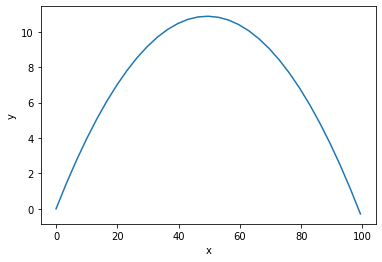

In [123]:
L_val,z_T_val, zt_val = forward(ts=ts)

plt.plot(zt_val[0,:],zt_val[1,:])
plt.xlabel('x')
plt.ylabel('y')